In [6]:
import pandas as pd  # Pandas is used for data manipulation and analysis, particularly for working with DataFrame structures.

from sklearn.preprocessing import StandardScaler  # StandardScaler is a preprocessing module from Scikit-learn that standardizes features by removing the mean and scaling to unit variance.

from sklearn.model_selection import train_test_split  # train_test_split is a utility function from Scikit-learn to split the dataset into training and testing sets.

import numpy as np  # NumPy is used for numerical operations, including working with arrays and performing mathematical functions.

import matplotlib.pyplot as plt  # Matplotlib is a plotting library used for creating static, animated, and interactive visualizations in Python.

from xgboost import XGBClassifier  # XGBClassifier is an implementation of the XGBoost algorithm, which is an efficient and scalable machine learning model used primarily for classification tasks.

from sklearn.metrics import classification_report, confusion_matrix  # These are evaluation metrics from Scikit-learn used to assess the performance of classification models.


In [4]:
!pip install pandas numpy scikit-learn geopandas folium matplotlib seaborn

In [9]:
# Load the dataset
file_path = r'C:/Users/Hanna/OneDrive - University of Stirling/Dataset/airline_information.csv'
df = pd.read_csv(file_path, low_memory=False)

In [11]:
# Check for missing values in each column
missing_values_per_column = df.isna().sum()
print("Missing values per column:\n", missing_values_per_column)

Missing values per column:
 Event Id                   0
Investigation Type         0
Accident Number            0
Event Date                 0
Location                   0
Country                    0
Latitude                   0
Longitude                  0
Airport Code               0
Airport Name               0
Injury Severity            0
Aircraft Damage            0
Aircraft Category          0
Registration Number        0
Make                       0
Model                      0
Amateur Built              0
Number of Engines          0
Engine Type                0
FAR Description            0
Schedule                   0
Purpose of Flight          0
Air Carrier                0
Total Fatal Injuries       0
Total Serious Injuries     0
Total Minor Injuries       0
Total Uninjured            0
Weather Condition          0
Broad Phase of Flight      0
Report Publication Date    0
Unnamed: 30                0
dtype: int64


In [13]:
# Check for rows with any missing values
rows_with_missing_values = df[df.isna().any(axis=1)]
print("Rows with missing values:\n", rows_with_missing_values)

Rows with missing values:
 Empty DataFrame
Columns: [Event Id, Investigation Type, Accident Number, Event Date, Location, Country, Latitude, Longitude, Airport Code, Airport Name, Injury Severity, Aircraft Damage, Aircraft Category, Registration Number, Make, Model, Amateur Built, Number of Engines, Engine Type, FAR Description, Schedule, Purpose of Flight, Air Carrier, Total Fatal Injuries, Total Serious Injuries, Total Minor Injuries, Total Uninjured, Weather Condition, Broad Phase of Flight, Report Publication Date, Unnamed: 30]
Index: []

[0 rows x 31 columns]


In [15]:
# Drop duplicates and handle missing values
df = df.drop_duplicates()
df = df.dropna(subset=['Event Id', 'Event Date', 'Location'])

In [17]:
# Clean and convert specific columns
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')

In [19]:
# Convert date columns to datetime format with error handling
df['Event Date'] = pd.to_datetime(df['Event Date'], errors='coerce')

In [21]:
# Drop rows with invalid dates and NaN values in numeric columns
df = df.dropna(subset=['Event Date', 'Latitude', 'Longitude'])

In [23]:
# Extract year from the event date
df['Year'] = df['Event Date'].dt.year

In [25]:
# Ensure there are non-null values in columns to be encoded
print("Non-null values in columns to be encoded:\n", df[['Weather Condition', 'Aircraft Category', 'Engine Type']].notna().sum())

Non-null values in columns to be encoded:
 Weather Condition    11959
Aircraft Category    11959
Engine Type          11959
dtype: int64


In [27]:
# Encode categorical variables
df_encoded = pd.get_dummies(df, columns=['Weather Condition', 'Aircraft Category', 'Engine Type'], dummy_na=True)

In [29]:
# Print the dataframe after encoding to ensure it's not empty
print("Dataframe after encoding:\n", df_encoded.head())

Dataframe after encoding:
           Event Id Investigation Type Accident Number Event Date  \
0  20080125X00106           Accident      SEA08CA056  2007-12-31   
1  20080206X00141           Accident      CHI08WA075  2007-12-31   
2  20080129X00122           Accident      CHI08CA057  2007-12-30   
3  20080114X00045           Accident      LAX08FA043  2007-12-30   
4  20080109X00032           Accident      NYC08FA071  2007-12-30   

                     Location           Country   Latitude   Longitude  \
0              Santa Ana, CA     United States   33.675556 -117.868056   
1   Guernsey, United Kingdom    United Kingdom   49.435000   -2.600278   
2             Alexandria, MN     United States   45.866111  -95.394444   
3            Paso Robles, CA     United States   35.542222 -120.522778   
4               Cherokee, AL     United States   34.688611  -87.920000   

  Airport Code                  Airport Name  ... Aircraft Category_nan  \
0         SNA    John Wayne - Orange County 

In [31]:
# Convert injury severity to numerical format
severity_mapping = {'Non-Fatal': 0, 'Fatal': 1}
df_encoded['Injury Severity'] = df['Injury Severity'].map(severity_mapping)

In [33]:
# Drop rows where Injury Severity is NaN
df_encoded = df_encoded.dropna(subset=['Injury Severity'])

In [35]:
# Ensure that the target variable has non-null values
print("Non-null values in target variable:\n", df_encoded['Injury Severity'].notna().sum())

Non-null values in target variable:
 0


In [37]:
# Select relevant features
features = ['Latitude', 'Longitude', 'Year']
weather_features = [col for col in df_encoded.columns if col.startswith('Weather Condition_')]
aircraft_features = [col for col in df_encoded.columns if col.startswith('Aircraft Category_')]
engine_features = [col for col in df_encoded.columns if col.startswith('Engine Type_')]
features.extend(weather_features)
features.extend(aircraft_features)
features.extend(engine_features)
target = 'Injury Severity'

# Print out the selected features for debugging
print("Selected features:", features)

Selected features: ['Latitude', 'Longitude', 'Year', 'Weather Condition_  ', 'Weather Condition_ IMC ', 'Weather Condition_ UNK ', 'Weather Condition_ VMC ', 'Weather Condition_nan', 'Aircraft Category_  ', 'Aircraft Category_ Airplane ', 'Aircraft Category_ Balloon ', 'Aircraft Category_ Blimp ', 'Aircraft Category_ Glider ', 'Aircraft Category_ Gyrocraft ', 'Aircraft Category_ Helicopter ', 'Aircraft Category_ Powered-Lift ', 'Aircraft Category_ Ultralight ', 'Aircraft Category_nan', 'Engine Type_  ', 'Engine Type_ REC, TJ, TJ ', 'Engine Type_ Reciprocating ', 'Engine Type_ Turbo Fan ', 'Engine Type_ Turbo Jet ', 'Engine Type_ Turbo Prop ', 'Engine Type_ Turbo Shaft ', 'Engine Type_ Unknown ', 'Engine Type_nan']


In [39]:
# Check if the selected features are in the dataframe
print("Selected features in the dataframe:", set(features).issubset(df_encoded.columns))

Selected features in the dataframe: True


In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from the CSV file
df = pd.read_csv('C:/Users/Hanna/OneDrive - University of Stirling/Dataset/airline_information.csv')

# Display the first few rows of the dataframe
print(df.head())

# Identify relevant columns
relevant_columns = [
    'Latitude', 'Longitude', 'Total Fatal Injuries', 'Total Serious Injuries', 
    'Total Minor Injuries', 'Total Uninjured', 'Weather Condition', 'Broad Phase of Flight'
]

# Remove rows with any empty cells in relevant columns
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
df.dropna(subset=relevant_columns, inplace=True)

# Convert necessary columns to numeric
numeric_columns = ['Latitude', 'Longitude', 'Total Fatal Injuries', 'Total Serious Injuries', 'Total Minor Injuries', 'Total Uninjured']
for column in numeric_columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')

# Drop rows where numeric conversion resulted in NaNs
df.dropna(subset=numeric_columns, inplace=True)

# Convert categorical features to numerical
categorical_columns = ['Weather Condition', 'Broad Phase of Flight']
for column in categorical_columns:
    df[column] = df[column].astype('category').cat.codes

# Create a target variable for Accident Severity
df['Accident Severity'] = df['Total Fatal Injuries'] + df['Total Serious Injuries']

# Selecting features and target
X = df[categorical_columns + numeric_columns]
y = df['Accident Severity']

# Check the resulting dataset size
print(f"Dataset size after preprocessing: {df.shape}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

# Training and evaluating models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred, average='weighted')}")
    print(f"Recall: {recall_score(y_test, y_pred, average='weighted')}")
    print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")
    print(f"AUC ROC: {roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')}")
    print(confusion_matrix(y_test, y_pred))
    print("\n")


C:\Users\Hanna\AppData\Local\Temp\ipykernel_8596\768209490.py:14: DtypeWarning: Columns (0,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:/Users/Hanna/OneDrive - University of Stirling/Dataset/airline_information.csv')


          Event Id Investigation Type Accident Number    Event Date  \
0  20080125X00106           Accident      SEA08CA056    12/31/2007    
1  20080206X00141           Accident      CHI08WA075    12/31/2007    
2  20080129X00122           Accident      CHI08CA057    12/30/2007    
3  20080114X00045           Accident      LAX08FA043    12/30/2007    
4  20080109X00032           Accident      NYC08FA071    12/30/2007    

                     Location           Country   Latitude    Longitude  \
0              Santa Ana, CA     United States   33.675556  -117.868056   
1   Guernsey, United Kingdom    United Kingdom      49.435    -2.600278   
2             Alexandria, MN     United States   45.866111   -95.394444   
3            Paso Robles, CA     United States   35.542222  -120.522778   
4               Cherokee, AL     United States   34.688611       -87.92   

  Airport Code                  Airport Name  ... Purpose of Flight  \
0         SNA    John Wayne - Orange County   ...  

C:\Users\Hanna\AppData\Local\Temp\ipykernel_8596\768209490.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(r'^\s*$', np.nan, regex=True, inplace=True)


Dataset size after preprocessing: (214, 32)


C:\Users\Hanna\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Hanna\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Hanna\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with 

Logistic Regression Performance:
Accuracy: 0.8604651162790697
Precision: 0.804263565891473
Recall: 0.8604651162790697
F1 Score: 0.8305517555859553


ValueError: Number of classes in y_true not equal to the number of columns in 'y_score'

In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# Load the data from the CSV file
file_path = 'C:/Users/Hanna/OneDrive - University of Stirling/Dataset/airline_information.csv'
df = pd.read_csv(file_path)

# Identify relevant columns
relevant_columns = [
    'Latitude', 'Longitude', 'Total Fatal Injuries', 'Total Serious Injuries', 
    'Total Minor Injuries', 'Total Uninjured', 'Weather Condition', 'Broad Phase of Flight'
]

# Remove rows with any empty cells in relevant columns
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
df.dropna(subset=relevant_columns, inplace=True)

# Convert necessary columns to numeric
numeric_columns = ['Latitude', 'Longitude', 'Total Fatal Injuries', 'Total Serious Injuries', 'Total Minor Injuries', 'Total Uninjured']
for column in numeric_columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')

# Drop rows where numeric conversion resulted in NaNs
df.dropna(subset=numeric_columns, inplace=True)

# Convert categorical features to numerical
categorical_columns = ['Weather Condition', 'Broad Phase of Flight']
for column in categorical_columns:
    df[column] = df[column].astype('category').cat.codes

# Create a target variable for Accident Severity
df['Accident Severity'] = df['Total Fatal Injuries'] + df['Total Serious Injuries']

# Selecting features and target
X = df[categorical_columns + numeric_columns]
y = df['Accident Severity']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

# Training and evaluating models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Output performance metrics
    print(f"{name} Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred, average='weighted', zero_division=1)}")
    print(f"Recall: {recall_score(y_test, y_pred, average='weighted', zero_division=1)}")
    print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")
    
    # Check if the model supports probability predictions and if so, calculate AUC ROC
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
        try:
            print(f"AUC ROC: {roc_auc_score(y_test, y_proba, multi_class='ovr')}")
        except ValueError as e:
            print(f"AUC ROC could not be calculated: {e}")
    
    print(confusion_matrix(y_test, y_pred))
    print("\n")


C:\Users\Hanna\AppData\Local\Temp\ipykernel_8596\103420424.py:11: DtypeWarning: Columns (0,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\Hanna\AppData\Local\Temp\ipykernel_8596\103420424.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
C:\Users\Hanna\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options

Logistic Regression Performance:
Accuracy: 0.8604651162790697
Precision: 0.8972868217054264
Recall: 0.8604651162790697
F1 Score: 0.8305517555859553
AUC ROC could not be calculated: Number of classes in y_true not equal to the number of columns in 'y_score'
[[17  0  0  0  0  0  0]
 [ 0 14  0  0  0  0  0]
 [ 0  2  6  0  0  0  0]
 [ 0  0  2  0  0  0  0]
 [ 0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0]]


Decision Tree Performance:
Accuracy: 0.9767441860465116
Precision: 1.0
Recall: 0.9767441860465116
F1 Score: 0.9767441860465116
AUC ROC could not be calculated: Number of classes in y_true not equal to the number of columns in 'y_score'
[[17  0  0  0  0  0  0]
 [ 0 14  0  0  0  0  0]
 [ 0  0  8  0  0  0  0]
 [ 0  0  0  2  0  0  0]
 [ 0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0]]


Random Forest Performance:
Accuracy: 0.9534883720930233
Precision: 0.9844961240310078
Recall: 0.9534883720930233
F1 Score: 0.944186046511628
AUC ROC could not be cal

In [53]:
unique_train_classes = np.unique(y_train)
unique_test_classes = np.unique(y_test)

print(f"Classes in y_train: {unique_train_classes}")
print(f"Classes in y_test: {unique_test_classes}")


Classes in y_train: [ 0  1  2  3  4  5  6  7 10]
Classes in y_test: [0 1 2 3 4 6]


In [55]:
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score

# Binarize y_test using classes from y_train
lb = LabelBinarizer().fit(y_train)
y_test_binarized = lb.transform(y_test)

# Initialize y_score with zeros for the full set of classes in y_train
y_score_padded = np.zeros((len(y_test), len(lb.classes_)))

# Get the predicted probabilities from the model
y_score_proba = model.predict_proba(X_test)

# Fill in the corresponding columns in y_score_padded
for i, class_label in enumerate(lb.classes_):
    if class_label in np.unique(y_test):
        class_index = list(np.unique(y_test)).index(class_label)
        y_score_padded[:, i] = y_score_proba[:, class_index]

# Calculate AUC ROC using the padded y_score
roc_auc_scores = []
for i in range(y_test_binarized.shape[1]):
    if len(np.unique(y_test_binarized[:, i])) > 1:  # Ensure the class is present in both positive and negative samples
        try:
            roc_auc = roc_auc_score(y_test_binarized[:, i], y_score_padded[:, i])
            roc_auc_scores.append(roc_auc)
            print(f"AUC ROC for class {lb.classes_[i]}: {roc_auc}")
        except ValueError as e:
            print(f"AUC ROC could not be calculated for class {lb.classes_[i]}: {e}")
    else:
        print(f"Skipping AUC ROC for class {lb.classes_[i]} due to lack of positive and negative samples.")

# If you want a macro average ROC AUC (across all classes):
if roc_auc_scores:
    macro_roc_auc = np.mean(roc_auc_scores)
    print(f"Macro AUC ROC across classes: {macro_roc_auc}")
else:
    print("No valid AUC ROC scores could be calculated.")


AUC ROC for class 0: 1.0
AUC ROC for class 1: 1.0
AUC ROC for class 2: 1.0
AUC ROC for class 3: 1.0
AUC ROC for class 4: 1.0
Skipping AUC ROC for class 5 due to lack of positive and negative samples.
AUC ROC for class 6: 1.0
Skipping AUC ROC for class 7 due to lack of positive and negative samples.
Skipping AUC ROC for class 10 due to lack of positive and negative samples.
Macro AUC ROC across classes: 1.0


In [61]:
# Create a GeoDataFrame for geospatial analysis *
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

# Create a base map
m = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=2)

# Add accident locations to the map
for _, row in gdf.iterrows():
    folium.CircleMarker(location=[row['Latitude'], row['Longitude']],
                        radius=5,
                        weight=2,
                        color='red' if row['Accident Severity'] > 0 else 'green',
                        fill=True,
                        fill_color='red' if row['Accident Severity'] > 0 else 'green'
                       ).add_to(m)

# Save the map as an HTML file
m.save("air_accident_hotspots.html")

In [63]:
import joblib

# Train the best model on the full dataset
best_model = models["Gradient Boosting"]
best_model.fit(X, y)

# Save the model
joblib.dump(best_model, 'best_model.pkl')


['best_model.pkl']

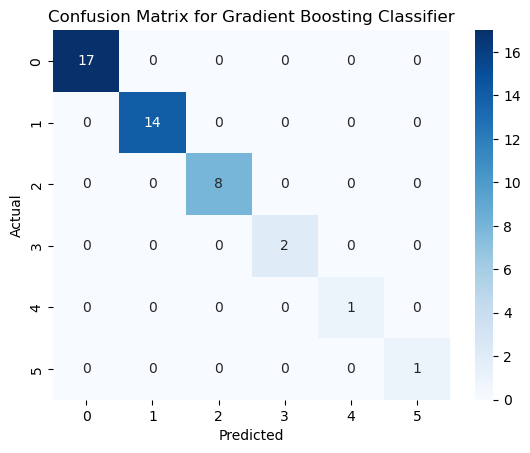

In [64]:
# Detailed confusion matrix for the best model *
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Gradient Boosting Classifier')
plt.show()

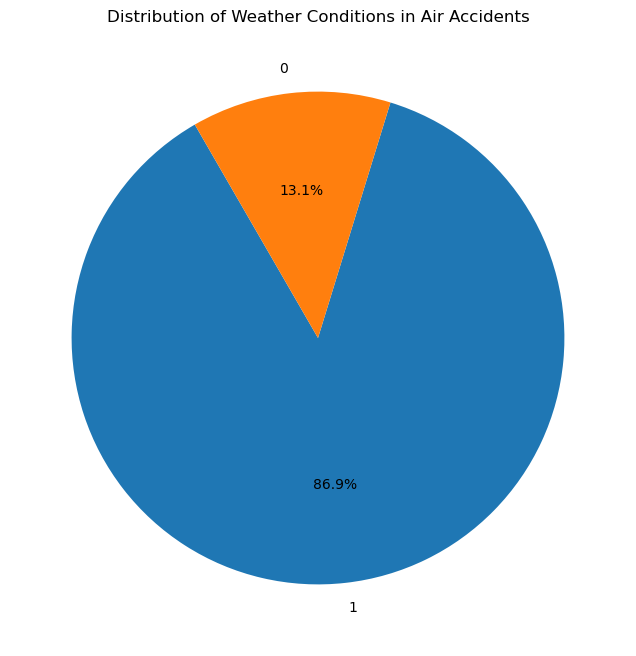

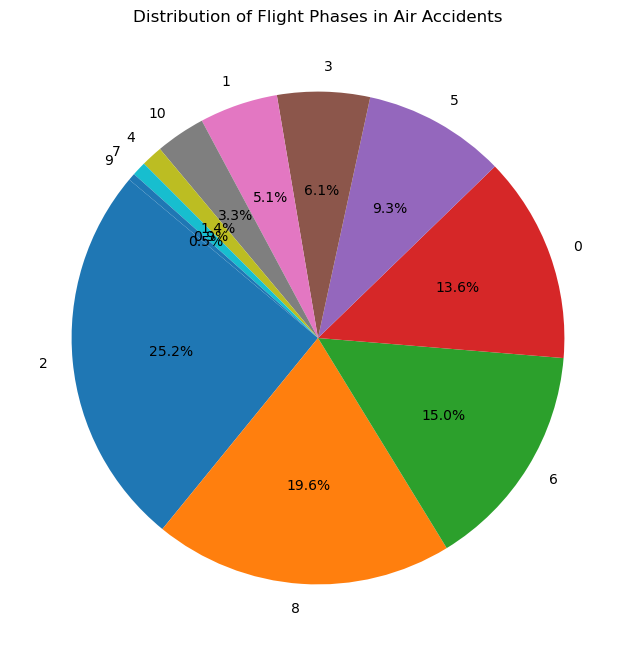

In [66]:
# Distribution of accident causes (Weather Condition and Broad Phase of Flight)
plt.figure(figsize=(8, 8))
df['Weather Condition'].value_counts().plot.pie(autopct='%1.1f%%', startangle=120)
plt.title('Distribution of Weather Conditions in Air Accidents')
plt.ylabel('')
plt.show()

plt.figure(figsize=(8, 8))
df['Broad Phase of Flight'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Flight Phases in Air Accidents')
plt.ylabel('')
plt.show()


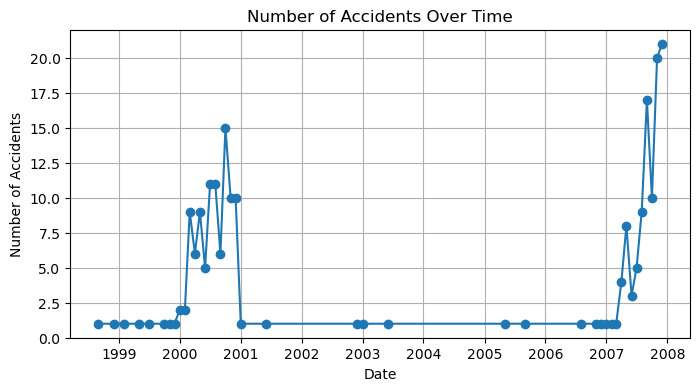

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'Event Date' is in datetime format
df['Event Date'] = pd.to_datetime(df['Event Date'], errors='coerce')

# Drop rows with NaT in 'Event Date' after conversion
df = df.dropna(subset=['Event Date'])

# Number of accidents over time
accidents_over_time = df.groupby(df['Event Date'].dt.to_period('M')).size()
accidents_over_time.index = accidents_over_time.index.to_timestamp()

# Plotting the number of accidents over time
plt.figure(figsize=(8, 4))
plt.plot(accidents_over_time.index, accidents_over_time, marker='o')
plt.title('Number of Accidents Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.grid(True)
plt.show()
